# Cópulas

Comencemos con un caso de ejemplo. Digamos que medimos dos variables que no están Normalmente distribuidas. Por ejemplo, observamos varios ríos y para cada río observamos el nivel máximo de ese río durante un cierto período de tiempo. Además, también contamos cuántos meses cada río causó inundaciones. La distribución de probabilidad del nivel máximo del río es una Gumbel. La cantidad de veces que se produjo una inundación se modela de acuerdo con una distribución Beta.

Es bastante razonable suponer que el nivel máximo y el número de inundaciones van a estar correlacionados. Si un río crece demasiado es probable que también haya inundaciones. Sin embargo, aquí nos encontramos con un problema: ¿cómo debemos modelar esa distribución de probabilidad? Arriba solo especificamos las distribuciones para las variables individuales, independientemente de la otra (es decir, los marginales). En realidad, estamos lidiando con una distribución conjunta de ambas variables juntas.

Cópulas al rescate.

Las cópulas nos permiten descomponer una distribución de probabilidad conjunta en sus marginales (que, por definición, no tienen correlación). Es una función que las une y, por tanto, nos permite especificar la correlación por separado.

Antes de sumergirnos en ello, primero debemos aprender cómo podemos transformar variables aleatorias arbitrarias en uniformes y viceversa. Todo lo que necesitaremos es el excelente módulo `scipy.stats` y `seaborn` para dibujar.

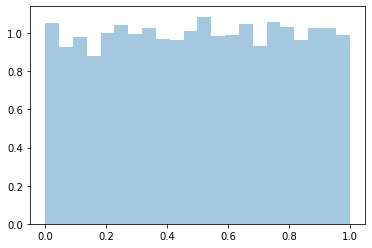

In [1]:
# Veamos la utilidad de las funciones cópulas.
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# Vamos a generar datos uniformemente distribuidos
x = stats.uniform(0, 1).rvs(10000)
sns.distplot(x, kde=False, norm_hist=True);

A continuación, queremos transformar estas muestras para que, en lugar de uniformes, ahora estén Normalmente distribuidas. La transformación que hace esto es la inversa de la función de distribución (o densidad acumulada) (CDF) de la distribución normal (que podemos obtener en `scipy.stats` con `ppf`):

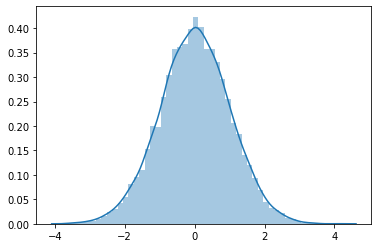

In [2]:
norm = stats.distributions.norm()
x_trans = norm.ppf(x)
sns.distplot(x_trans);

Si trazamos ambas juntas, podemos obtener una intuición de cómo se ve la CDF inversa y cómo funciona:

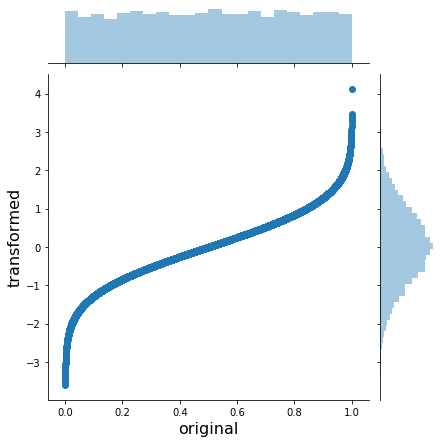

In [3]:
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

Como puedes ver, la CDF inversa estira las regiones externas de la uniforme para producir un normal.

Podemos hacer esto para distribuciones de probabilidad arbitrarias (univariadas), como la Beta:

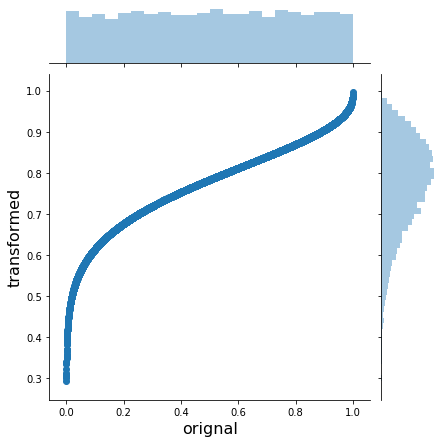

In [4]:
beta = stats.distributions.beta(a=10, b=3)
x_trans = beta.ppf(x)
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('orignal', 'transformed', fontsize=16);

O la Gumbel:

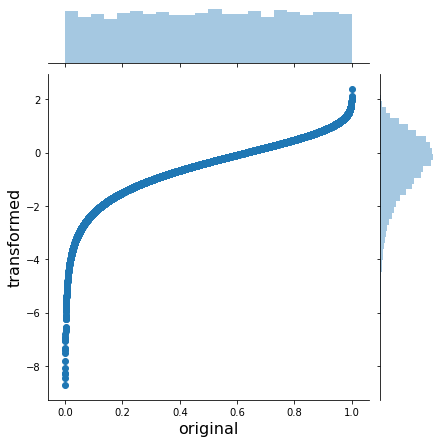

In [5]:
gumbel = stats.distributions.gumbel_l()
x_trans = gumbel.ppf(x)
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

Para hacer la transformación opuesta de una distribución arbitraria a la Uniforme(0, 1) simplemente aplicamos la inversa de la CDF inversa, es decir, la CDF:

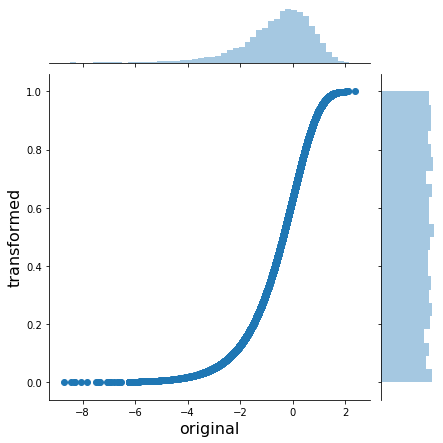

In [6]:
x_trans_trans = gumbel.cdf(x_trans)
h = sns.jointplot(x_trans, x_trans_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

Bien, entonces sabemos cómo transformar de cualquier distribución a uniforme y viceversa. En matemáticas, esto se llama la transformación integral de probabilidad.

**Añadiendo correlaciones mediante el uso de la Cópula Gaussiana.**

¿Cómo nos ayuda esto con nuestro problema de crear una distribución de probabilidad conjunta personalizada? En realidad ya casi hemos terminado. Sabemos cómo convertir cualquier cosa distribuida uniformemente en una distribución de probabilidad arbitraria. Eso significa que solo necesitamos generar datos distribuidos uniformemente con las correlaciones que queremos. ¿Como hacemos eso? Simulamos a partir de una Gaussiana multivariante con la estructura de correlación específica que queremos, transformamos para que los marginales sean uniformes, y luego transformamos los marginales uniformes a lo que queramos.

Vamos a crear muestras a partir de una Normal multivariante correlacionada:

In [0]:
mvnorm = stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.5], 
                                                     [0.5, 1.]])
# Generando la Normal multivariante con correlaciones .5
x = mvnorm.rvs(100000)

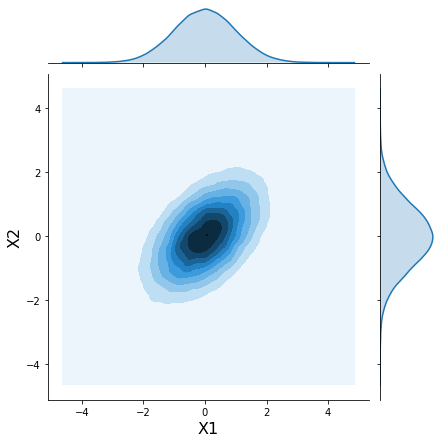

In [8]:
h = sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

Ahora usaremos lo que aprendimos arriba para "uniformizar" las marignales:

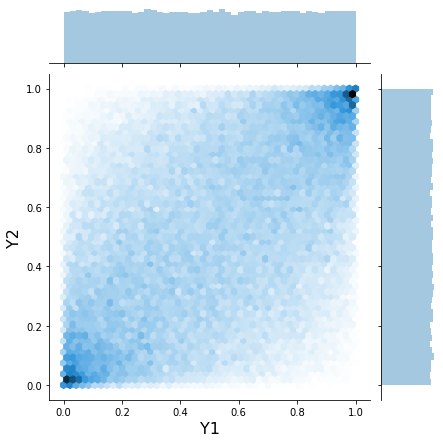

In [9]:
norm = stats.norm()
x_unif = norm.cdf(x)
h = sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2', fontsize=16);

Este diagrama conjunto suele ser cómo se visualizan las cópulas.

Ahora solo transformamos los marginales nuevamente a lo que queremos (Gumbel y Beta):

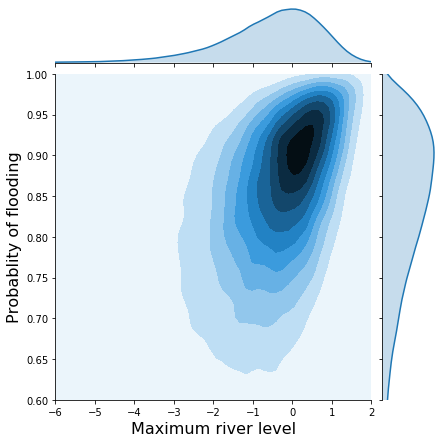

In [10]:
m1 = stats.gumbel_l()
m2 = stats.beta(a=10, b=2)

x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

h = sns.jointplot(x1_trans, x2_trans, kind='kde', xlim=(-6, 2), ylim=(.6, 1.0), stat_func=None);
h.set_axis_labels('Maximum river level', 'Probablity of flooding', fontsize=16);

Contrastemos eso con la distribución conjunta sin correlaciones:

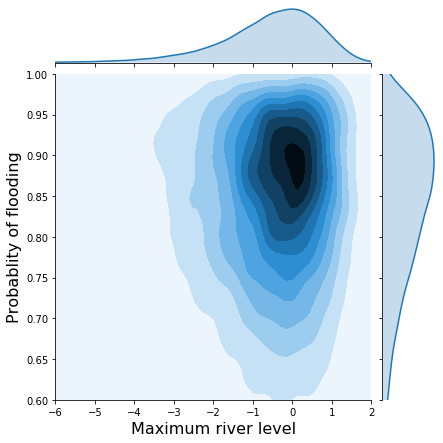

In [11]:
x1 = m1.rvs(10000)
x2 = m2.rvs(10000)

h = sns.jointplot(x1, x2, kind='kde', xlim=(-6, 2), ylim=(.6, 1.0), stat_func=None);
h.set_axis_labels('Maximum river level', 'Probablity of flooding',  fontsize=16);

Entonces, al usar la distribución Uniforme como nuestra base, podemos inducir fácilmente correlaciones y construir de manera flexible distribuciones de probabilidad complejas. Todo esto se extiende directamente a distribuciones de dimensiones superiores también.